In [7]:
### Import Libraries

# File manipulation

import os # For working with Operating System
from sys import platform # Diagnose operating system
import requests

# Analysis Libraries

import numpy as np # For working with Arrays
import pandas as pd # Data Manipulation
import geopandas as gpd # Spatial Data Manipulation
import rasterio
import numpy.ma as ma # Masking

# Visualization Libraries

import matplotlib.pyplot as plt # Basic Plotting
plt.style.use('ggplot') # 
import seaborn as sns # Statistical Plotting
import contextily # Base Map Visualization

import warnings
warnings.filterwarnings('ignore') # Ignores some warnings

In [8]:
# Load raster template

raster_path = os.path.join(os.getcwd(), '..', '2_Model_Pollutant_Exposure', 'template.npy')

raster = np.load(raster_path)

In [9]:
# Load rasterized exposures

# Filenames

path_to_tests = os.path.join(os.getcwd(),'..', '3_Hazard_Index', 'Tests')

filenames = os.listdir(path_to_tests)
layernames = []

tests = {}

for filename in filenames:

    path = os.path.join(path_to_tests, filename)
    
    layername = filename.split('_')[0]
    
    rasterio_rast = rasterio.open(path)
    
    tests[layername] = rasterio_rast.read(1)
    
    rasterio_rast.close()

In [10]:
# Load Interpolated PurpleAir

rasterio_rast = rasterio.open('PurpleAir_Interpolation_Normalized.tif')

PurpleAir = rasterio_rast.read(1)

rasterio_rast.close()

In [11]:
# Mask PurpleAir to just Minneapolis (for accuracy checks)

# Boundary

mpls_path = os.path.join(os.getcwd(), '..', '1_Data_IO', 'Data', 'mpls_boundary.geojson')
mpls = gpd.read_file(mpls_path)

# Bounds

extent = mpls.geometry.total_bounds # minx, miny, maxx, maxy

minx = extent[0]
miny = extent[1]
maxx = extent[2]
maxy = extent[3]


# Find indices of raster within bounds

in_bounds_x = np.logical_and(raster[0]>(minx), raster[0]<(maxx))
in_bounds_y = np.logical_and(raster[1]>(miny), raster[1]<(maxy))
in_bounds = np.logical_and(in_bounds_x, in_bounds_y)

# Select these from PurpleAir

PurpleAir_clipped = ma.array(PurpleAir.T, mask = np.invert(in_bounds))


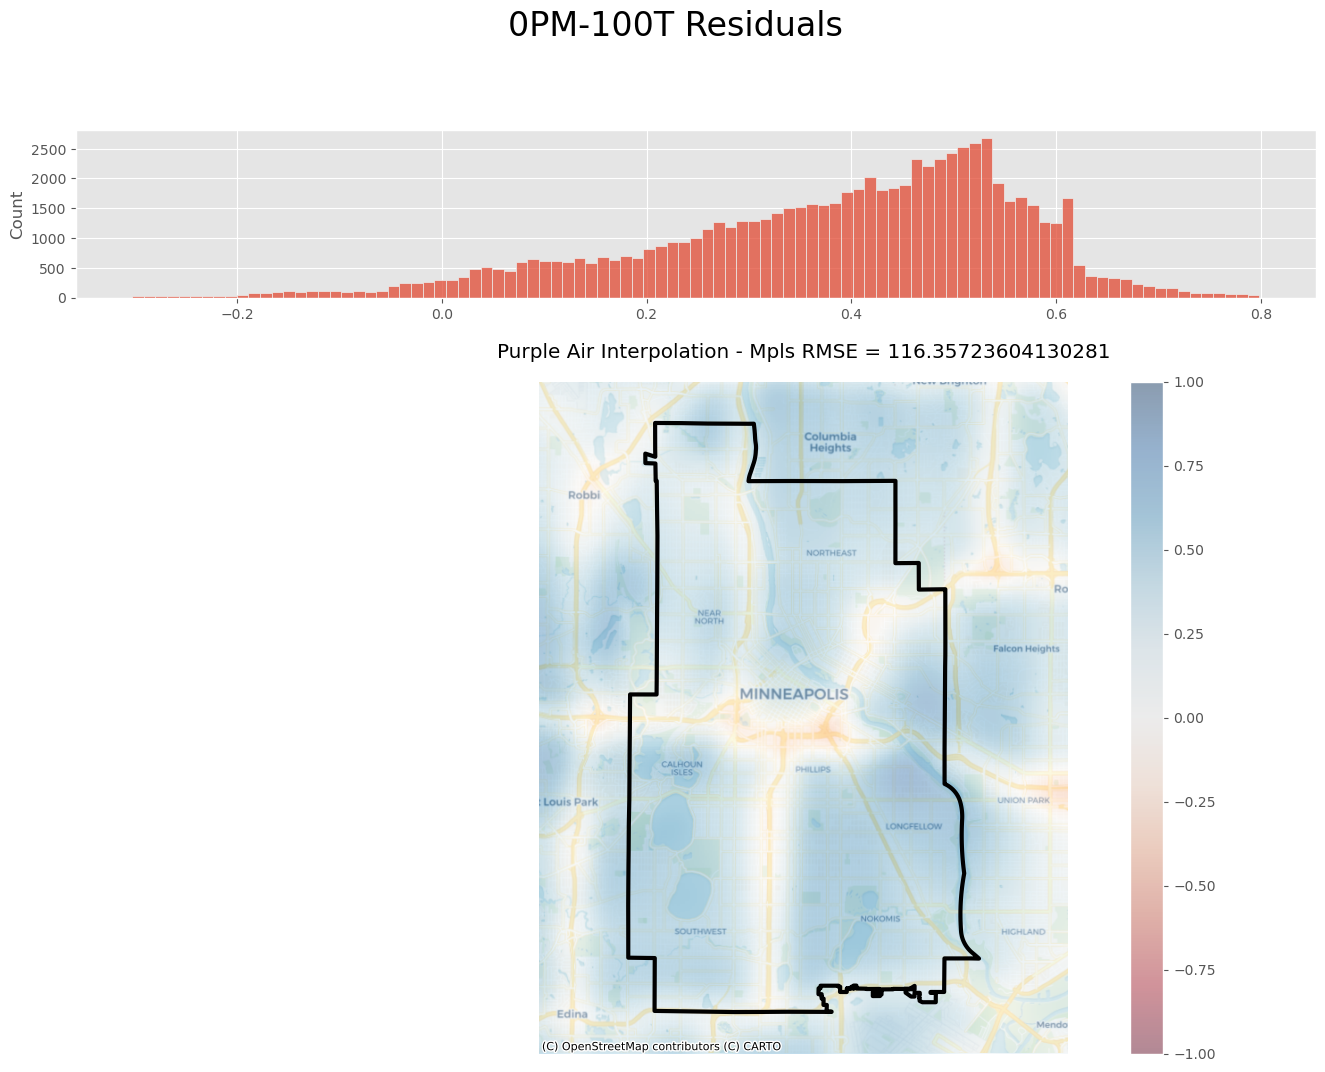

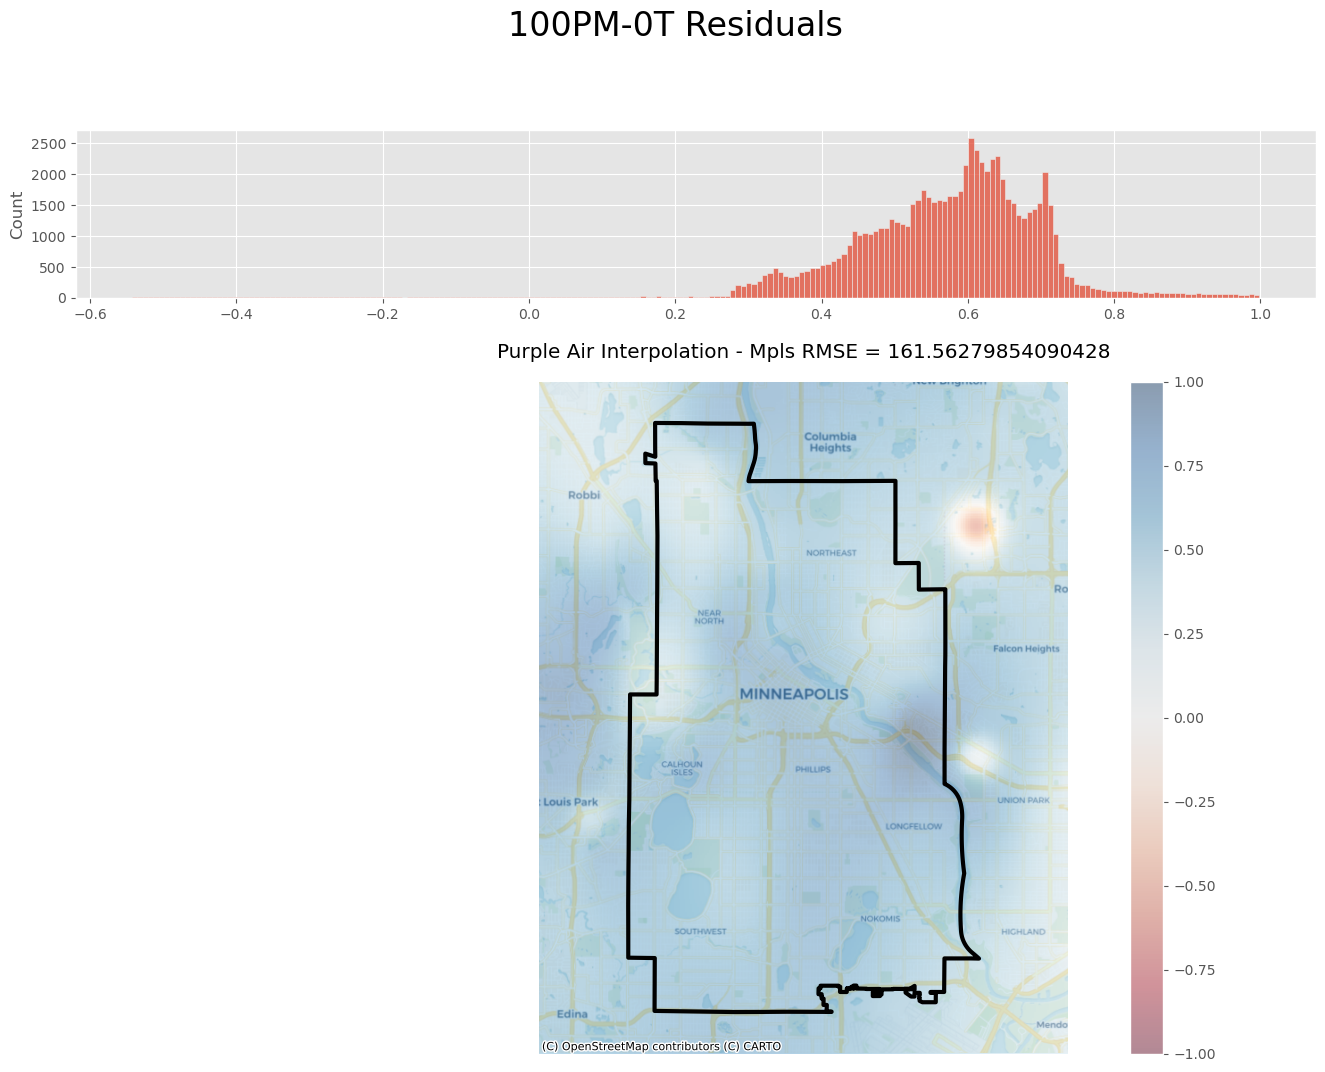

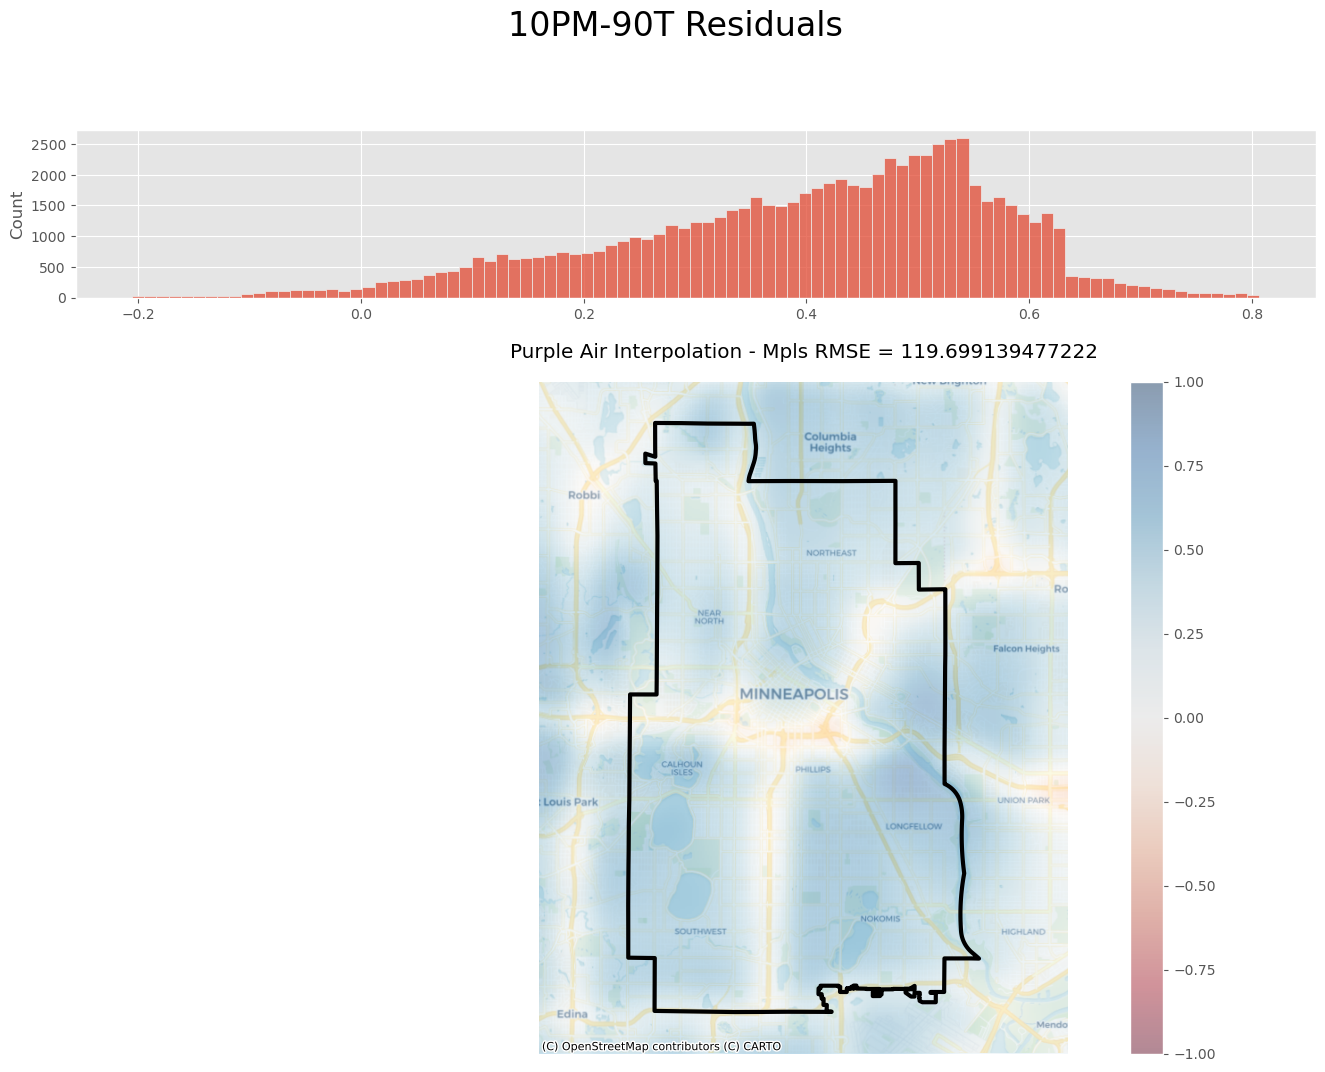

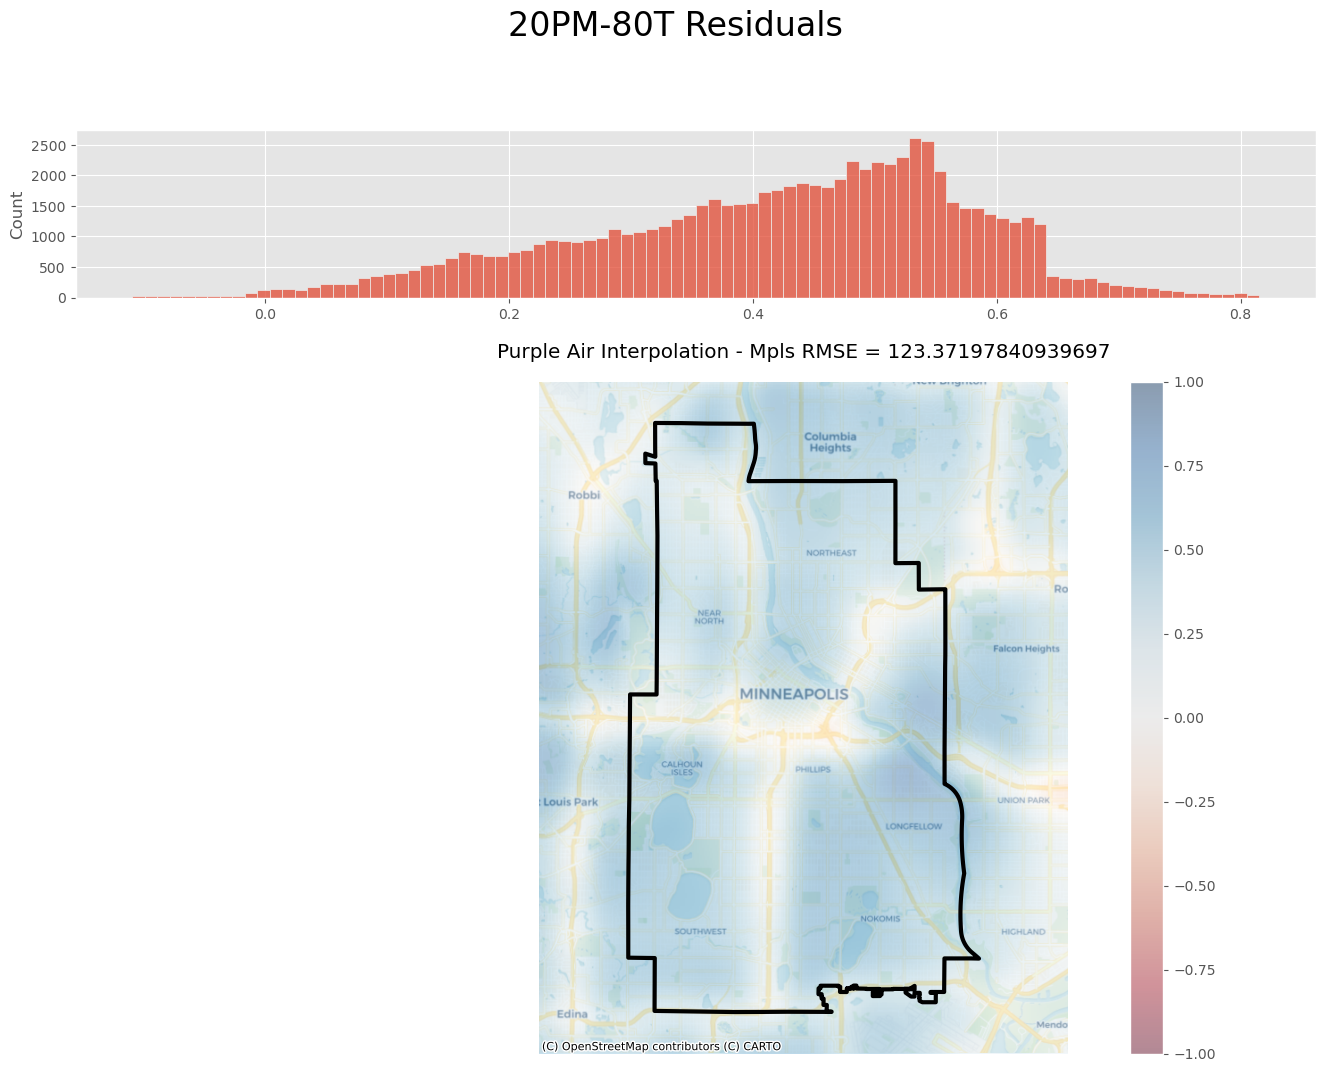

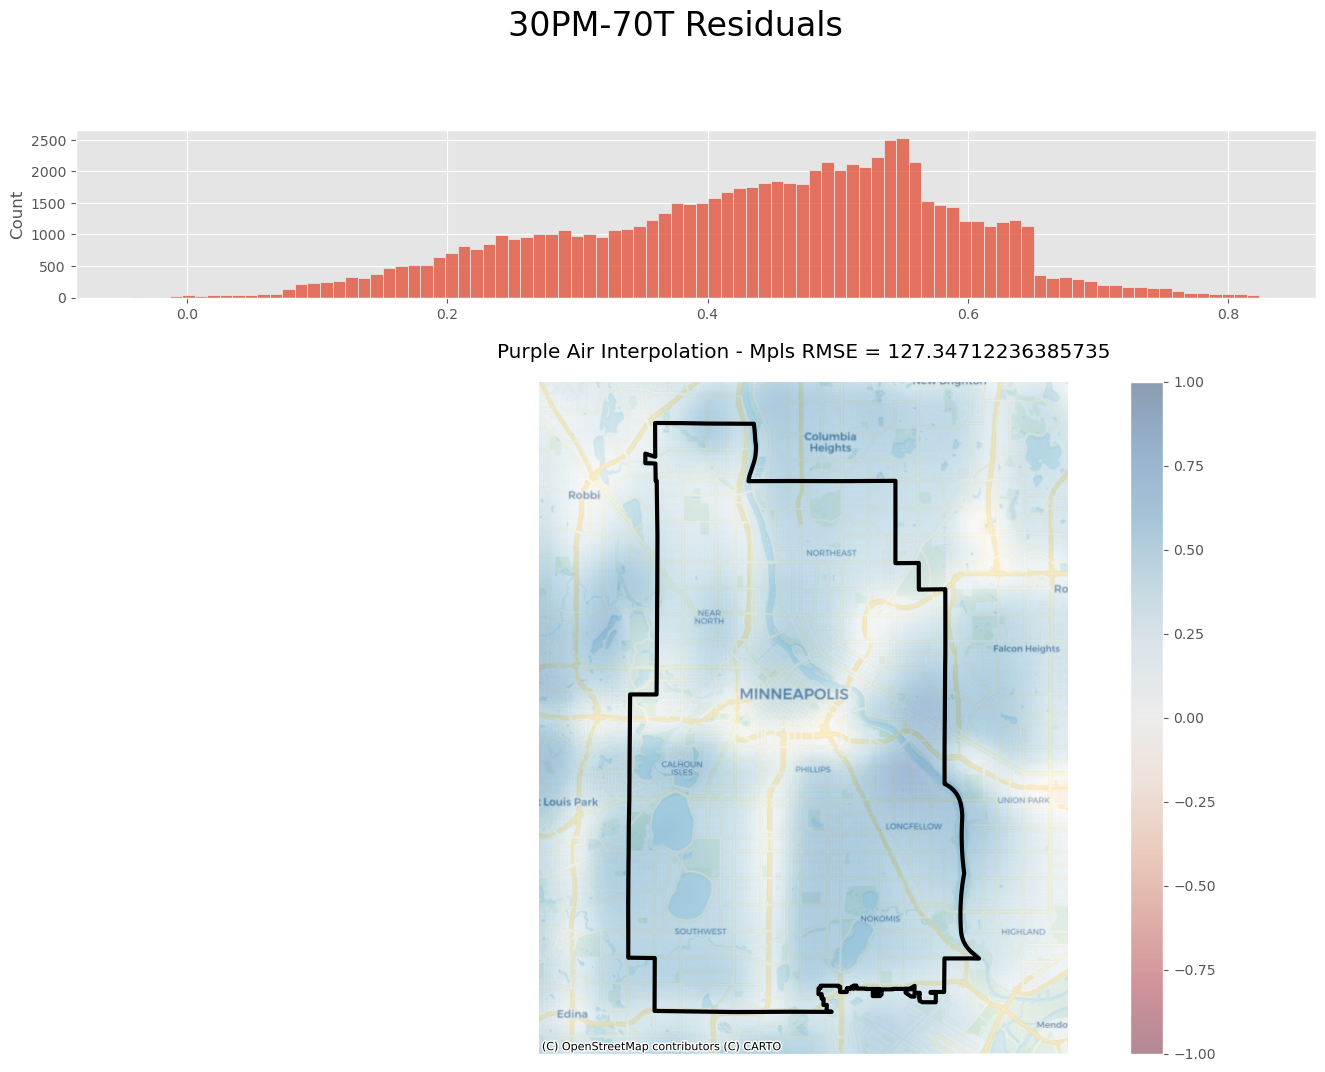

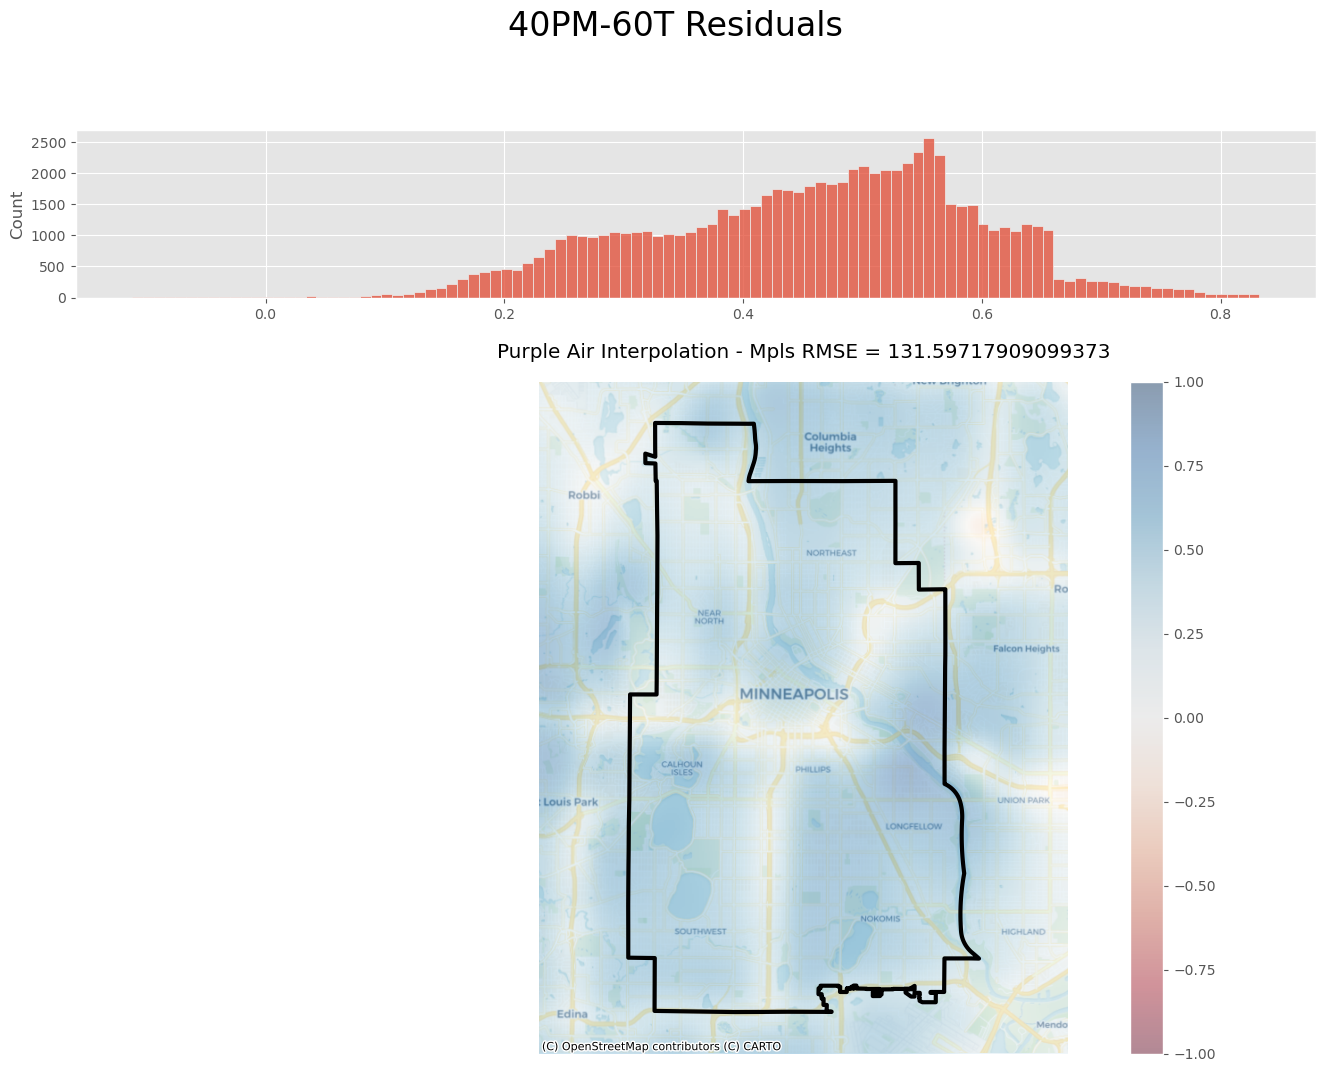

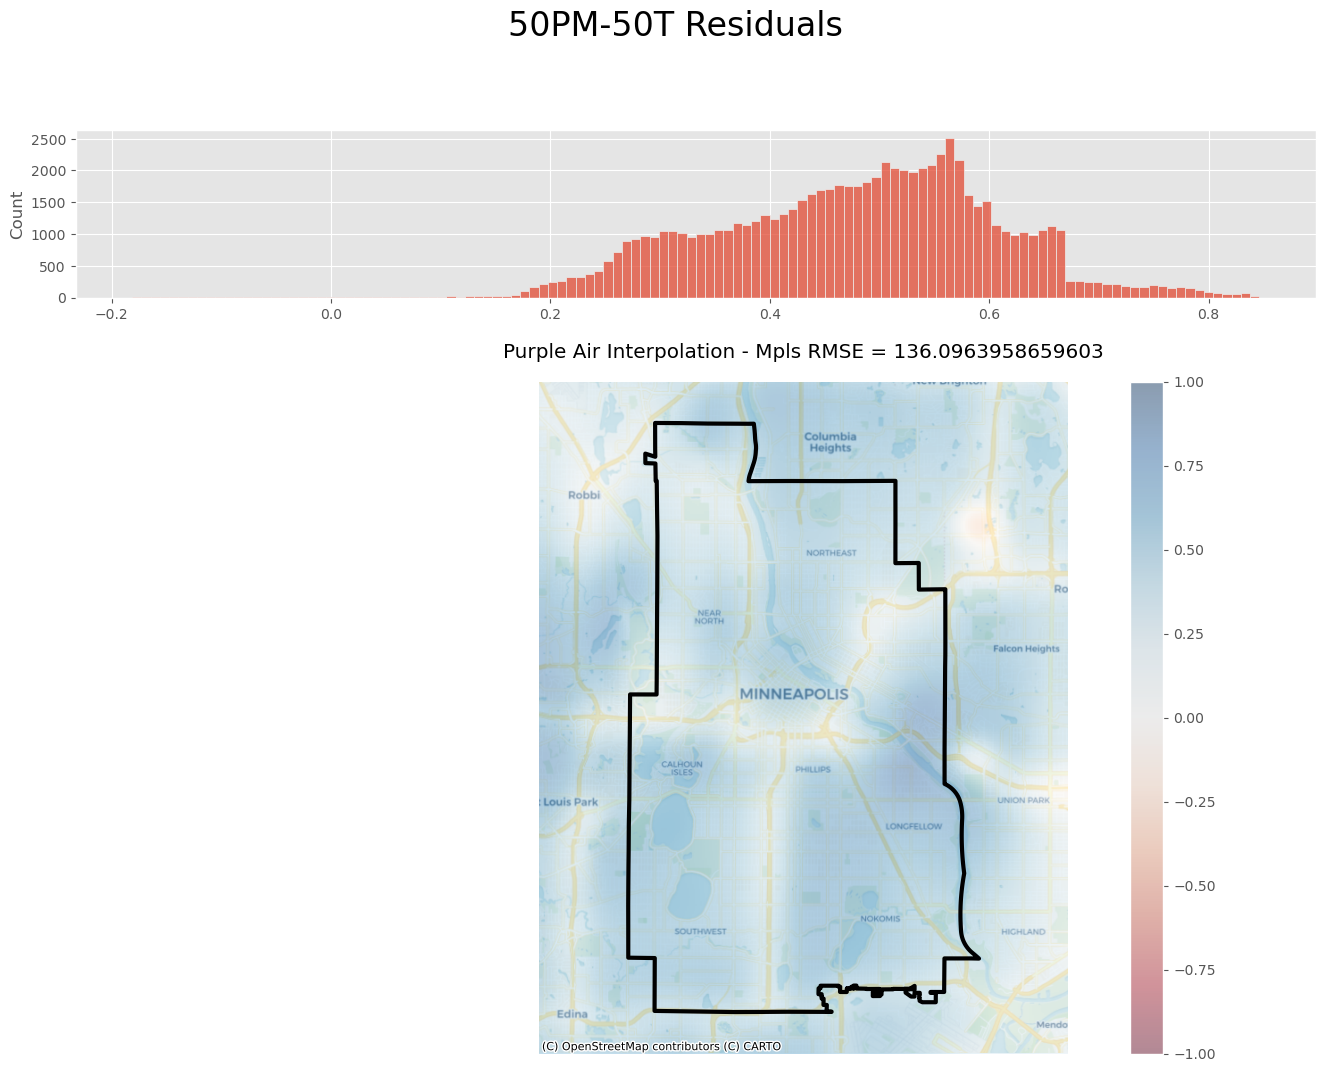

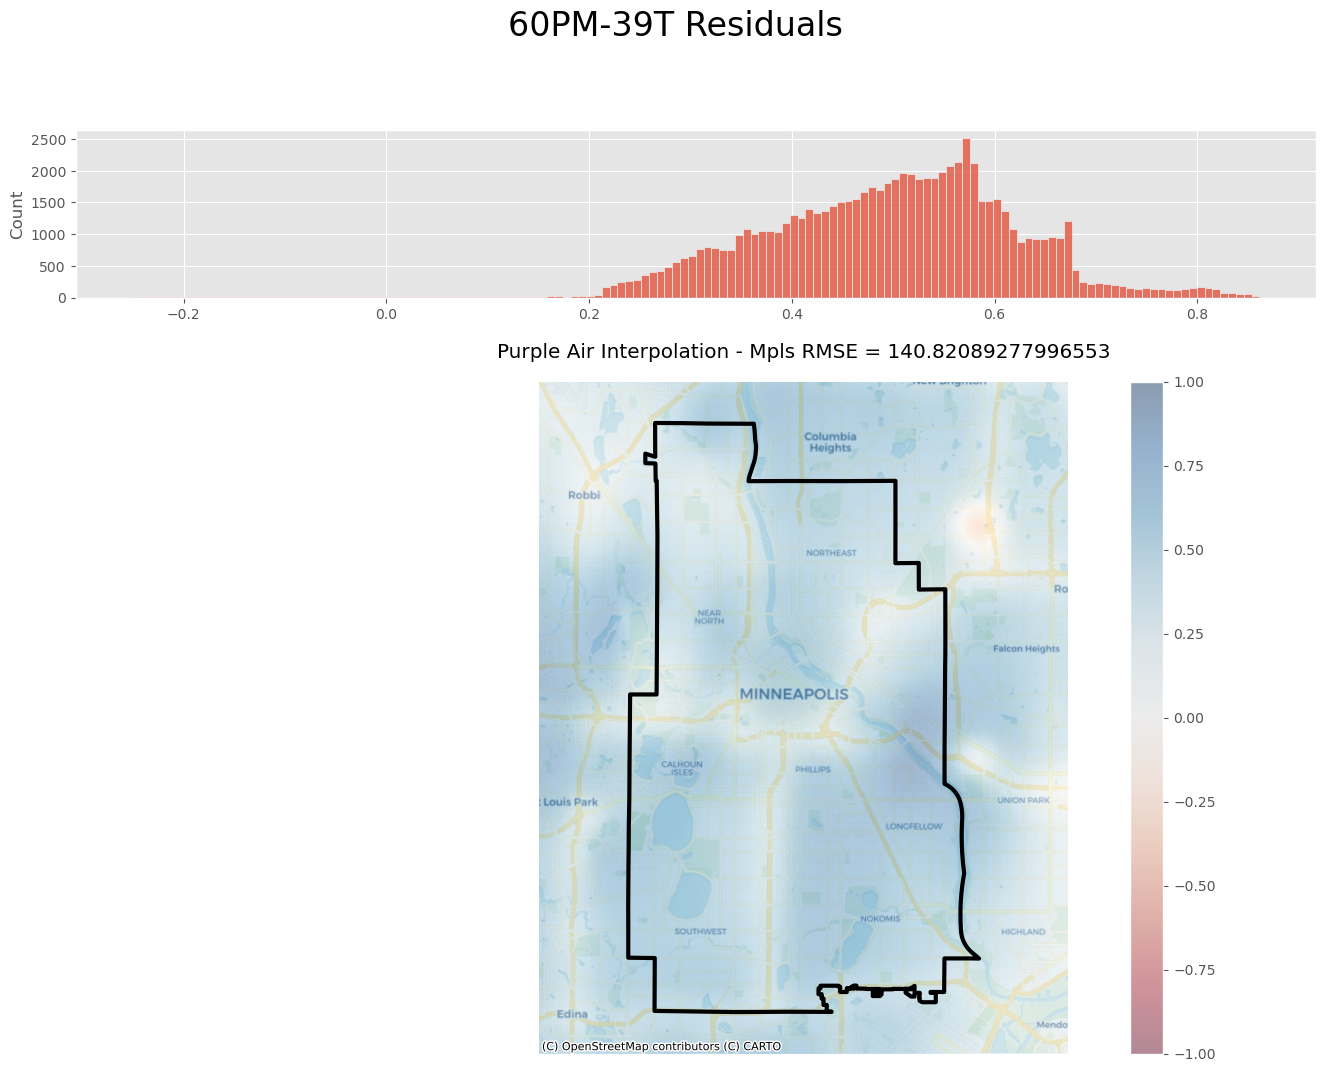

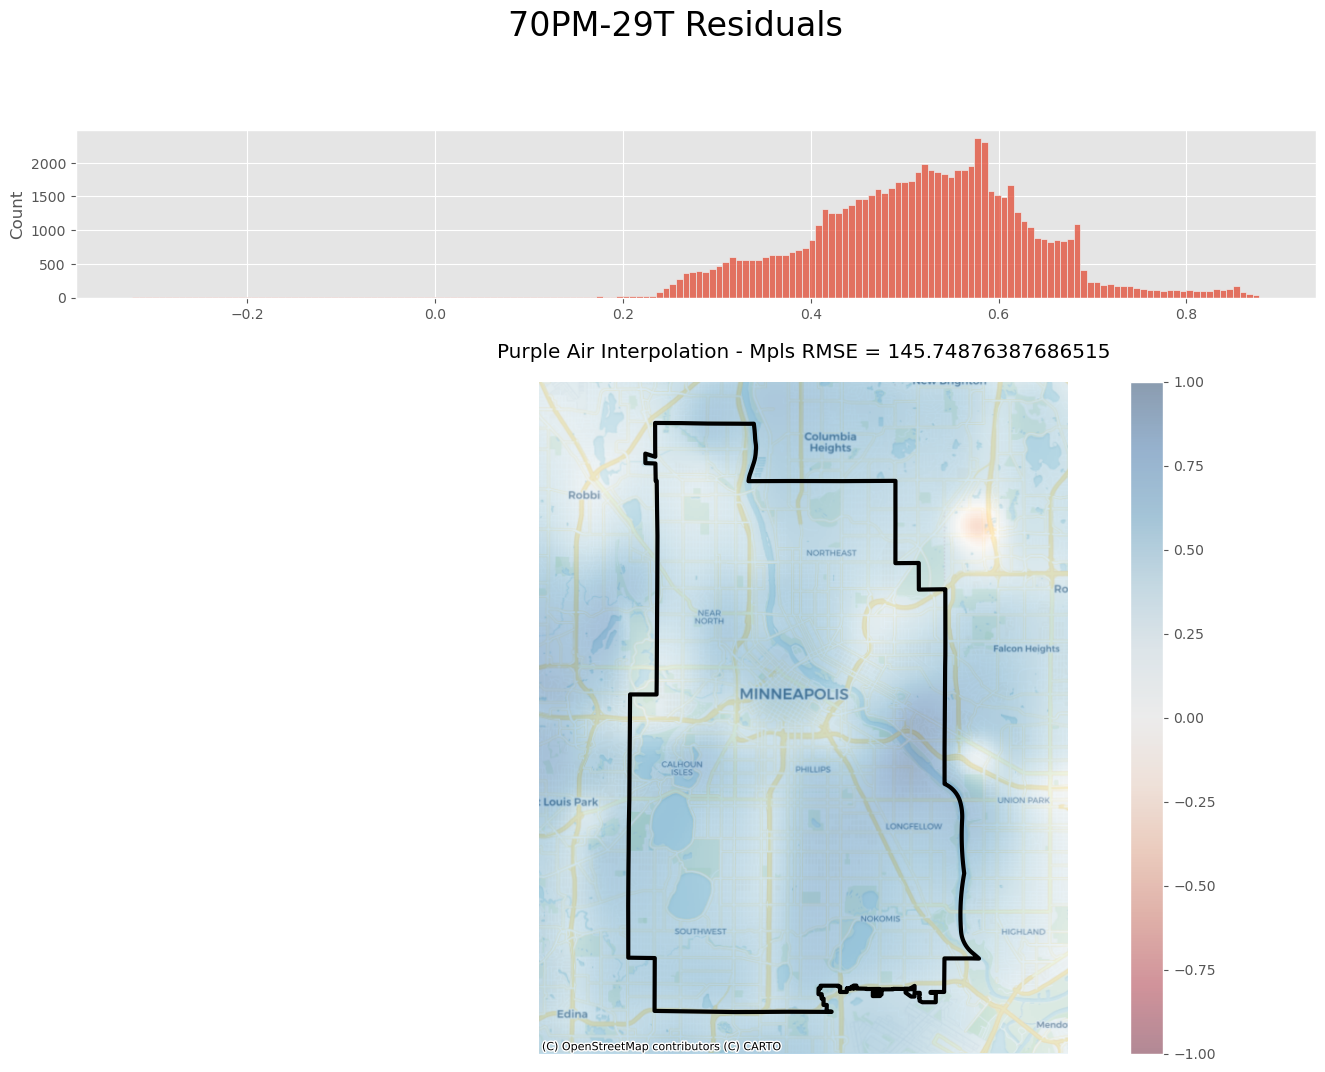

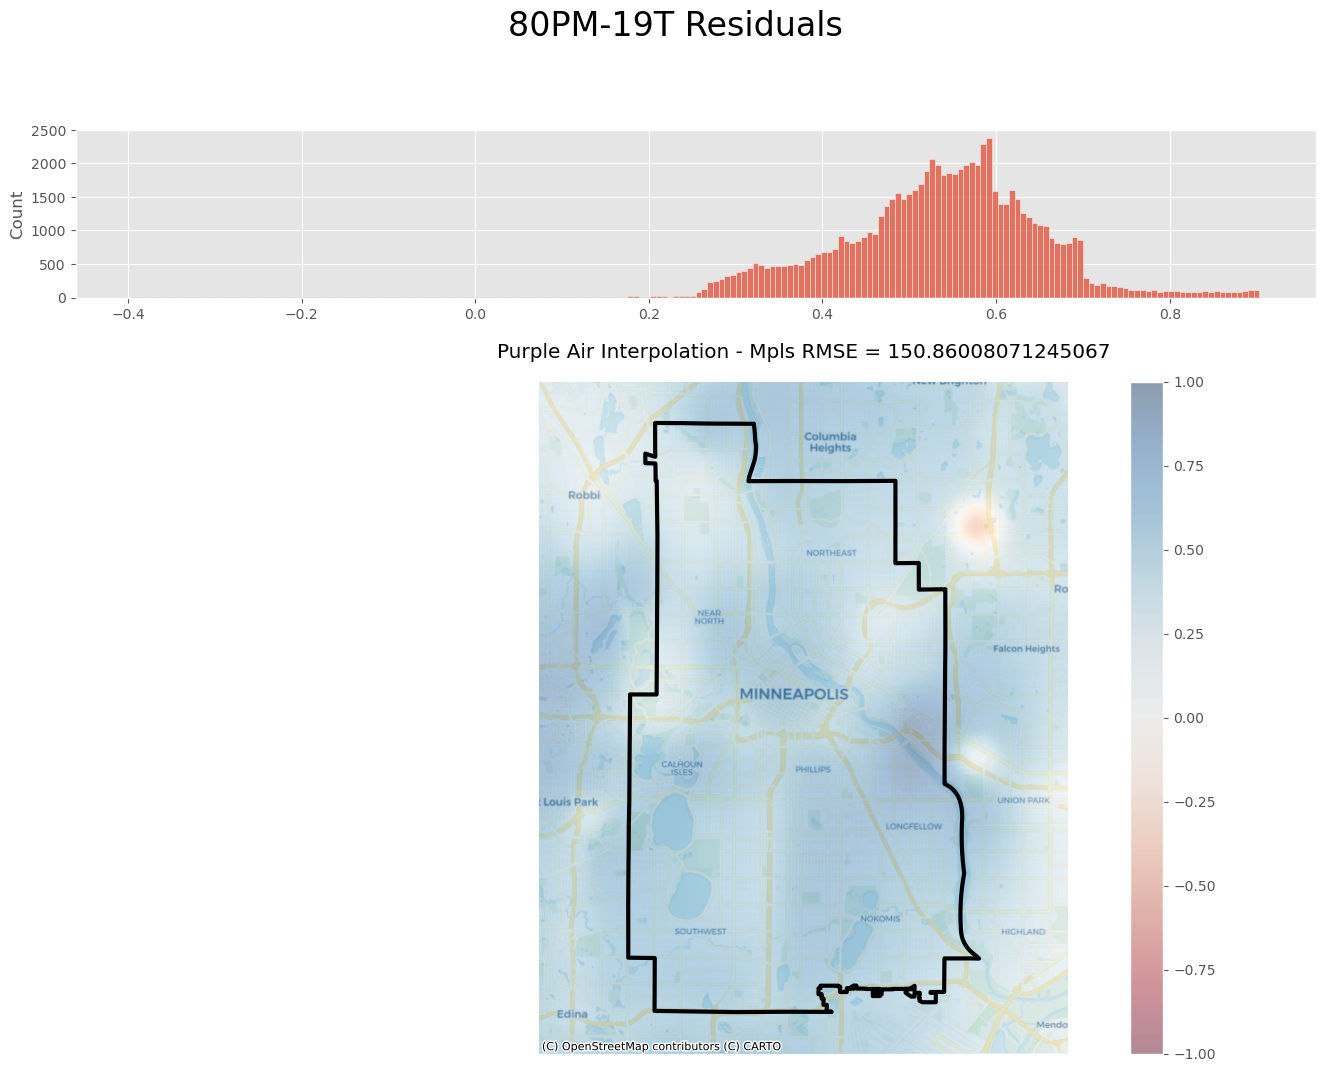

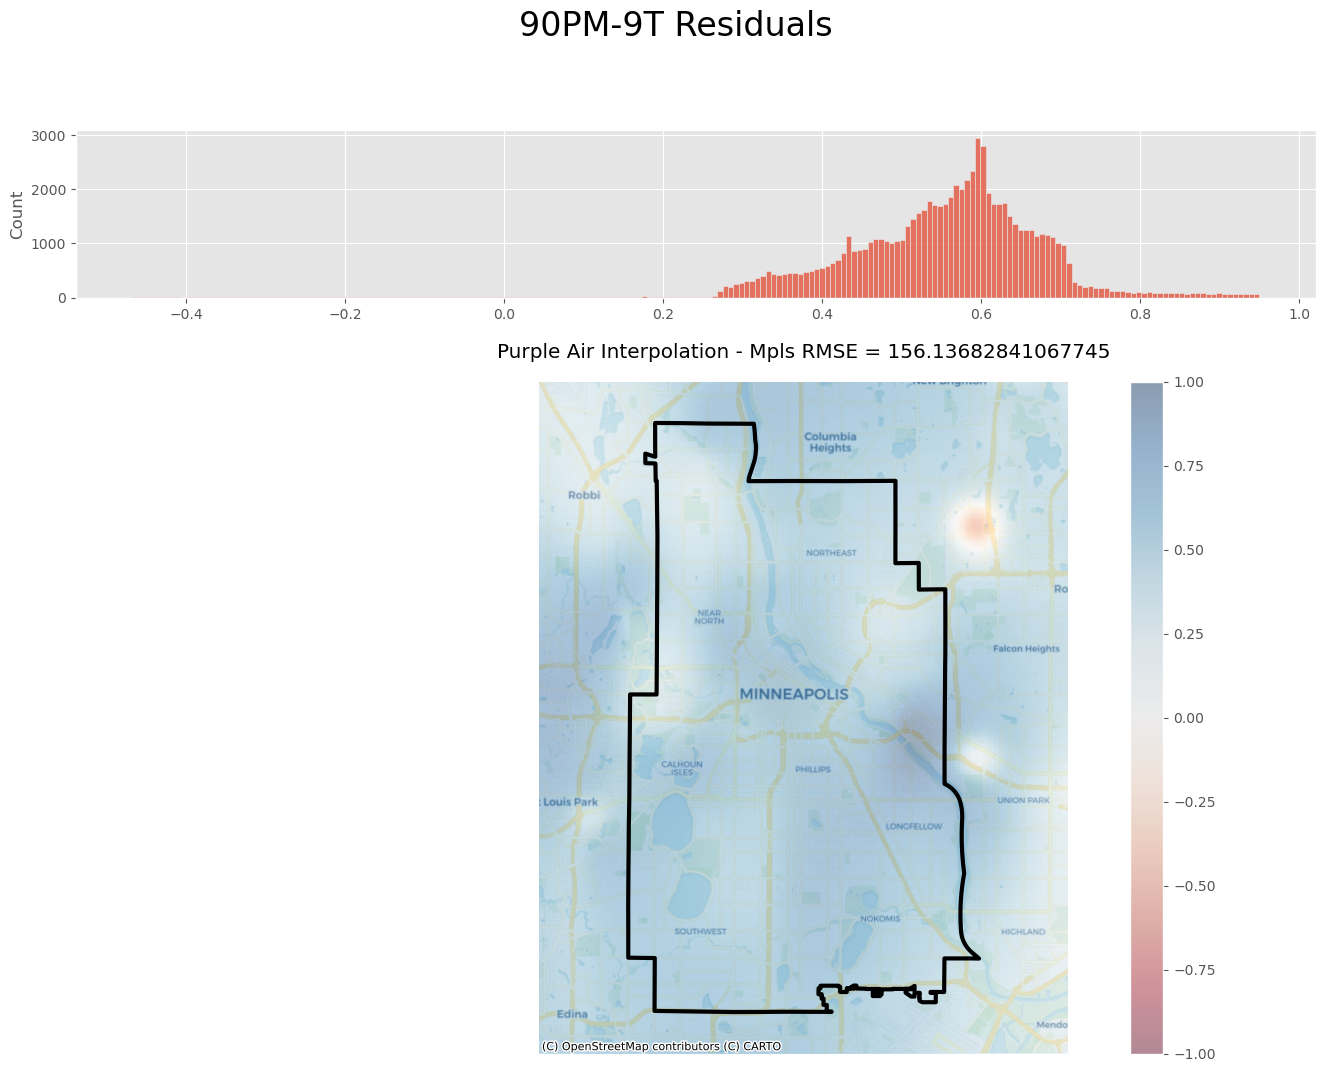

In [14]:
# Check residual

sorted_testnames = list(tests.keys())
sorted_testnames.sort()

for testname in sorted_testnames:
    
    # All residuals (for plotting)
    dif_full = PurpleAir - tests[testname]
    # Residuals and RMSE for just Minneapolis
    dif_mpls = PurpleAir_clipped - ma.array(tests[testname].T, mask = np.invert(in_bounds))
    rmse_mpls = np.sqrt(np.sum(dif_mpls**2))
    
    f, axs = plt.subplots(2, 1, figsize = (16, 12), height_ratios=[1, 4])
    
    f.suptitle(testname + ' Residuals', fontsize = 24)
    
    sns.histplot(dif_mpls.flatten(), ax = axs[0])

    art = axs[1].pcolormesh(raster[0], raster[1], dif_full.T,
                            shading='auto', cmap = 'RdBu',
                            vmin=-1, vmax=1,
                            alpha = 0.4) # Plot residual

    f.colorbar(art, ax = axs[1]) # Add colorbar
    title = 'Purple Air Interpolation - Mpls RMSE = ' + str(rmse_mpls)
    axs[1].set_title(title) # Add title
    axs[1].set_axis_off()
    
    # Add in minneapolis
    mpls.plot(ax = axs[1],
             edgecolor='black', facecolor='none',
             linewidth=3,
             zorder = 2,
             legend = True)
    
    axs[1].margins(x=-0.2, y=-0.2) # Zoom to mpls
    # Add basemap

    contextily.add_basemap(ax = axs[1], 
                           crs = 'EPSG:26915', 
                           source=contextily.providers.CartoDB.Voyager
                          ) 

    plt.show()

In [17]:
# Best one was 60 industry, 40 Traffic as far as rmse goes
# Tended to overpredict slightly